<br>

I used ResNet architecture with the imagenet weights.

<br>

## Predictions

<br>

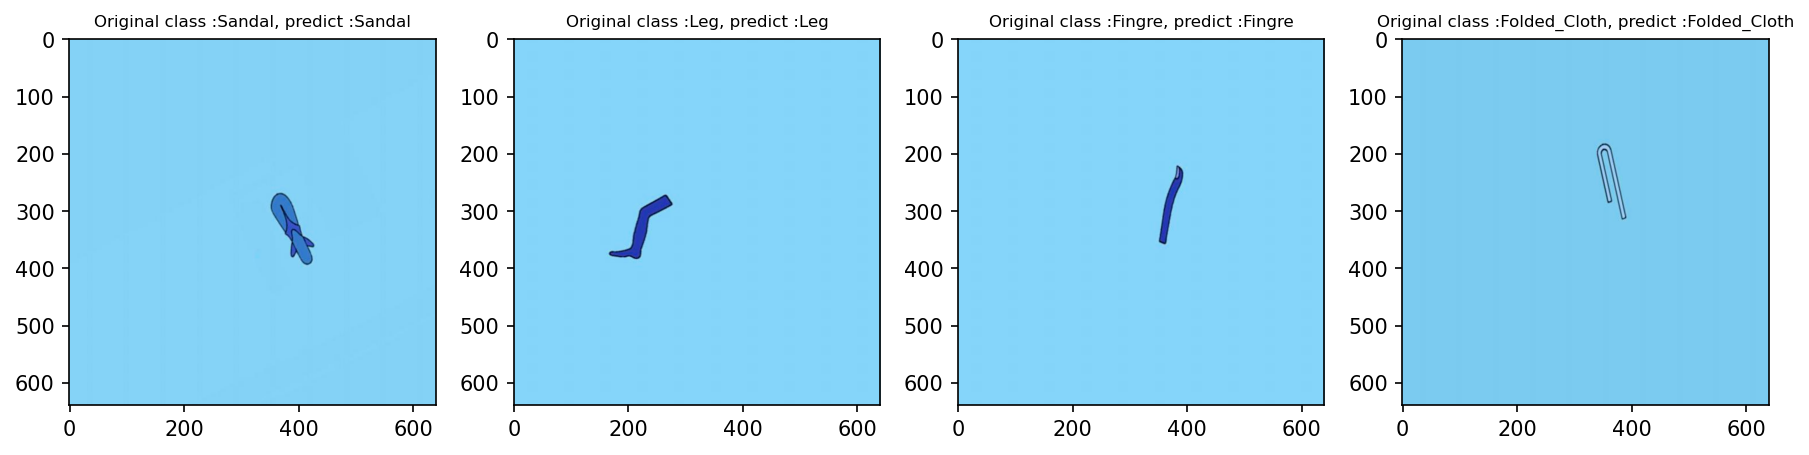


In [25]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import random

from sklearn.metrics import classification_report, confusion_matrix,average_precision_score

from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D,BatchNormalization, Activation,Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(10)

In [26]:
train_data = pd.read_csv('C:\\Users\\DELL\\Desktop\\pp\\pp\\archive (2)\\train\\_annotations.csv')
val_data = pd.read_csv('C:\\Users\\DELL\\Desktop\\pp\\pp\\archive (2)\\valid\\_annotations.csv')
test_data = pd.read_csv('C:\\Users\\DELL\\Desktop\\pp\\pp\\archive (2)\\test\\_annotations.csv')

In [27]:
oe = OrdinalEncoder()

# Encoding class labels in the train set
main_path_train = 'C:\\Users\\DELL\\Desktop\\pp\\pp\\archive (2)\\train/'
train_data['filename'] = train_data['filename'].apply(lambda x: main_path_train + x)

oe.fit(np.array(train_data['class']).reshape(-1,1))
train_data['class'] = oe.transform(np.array(train_data['class']).reshape(-1,1))

# Encoding class labels in the validation set
main_path_val = 'C:\\Users\\DELL\\Desktop\\pp\\pp\\archive (2)\\valid/'
val_data['filename'] = val_data['filename'].apply(lambda x: main_path_val + x)
val_data['class'] = oe.transform(np.array(val_data['class']).reshape(-1,1))


# Encoding class labels in the test set
main_path_test = 'C:\\Users\\DELL\\Desktop\\pp\\pp\\archive (2)\\test/'
test_data['filename'] = test_data['filename'].apply(lambda x: main_path_test + x)
test_data['class'] = oe.transform(np.array(test_data['class']).reshape(-1,1))

In [28]:
# Creating random 3 sample from a dataframe

def create_random_samples(data):
    fig, axs = plt.subplots(1,3, figsize = (12,5), dpi = 130)
    
    idx1 = random.randint(0,data.shape[0])
    img1 = cv2.imread(data['filename'][idx1])
    name1 = oe.inverse_transform(np.array(data['class'][idx1]).reshape(-1,1))[0][0]
    
    idx2 = random.randint(0,data.shape[0])
    img2 = cv2.imread(data['filename'][idx2])
    name2 = oe.inverse_transform(np.array(data['class'][idx2]).reshape(-1,1))[0][0]
    
    idx3 = random.randint(0,data.shape[0])
    img3 = cv2.imread(data['filename'][idx3])
    name3 = oe.inverse_transform(np.array(data['class'][idx3]).reshape(-1,1))[0][0]
    
    
    axs[0].imshow(img1)
    axs[0].set_title(name1)

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    
    axs[2].imshow(img3)
    axs[2].set_title(name3)
    
    
    plt.show()

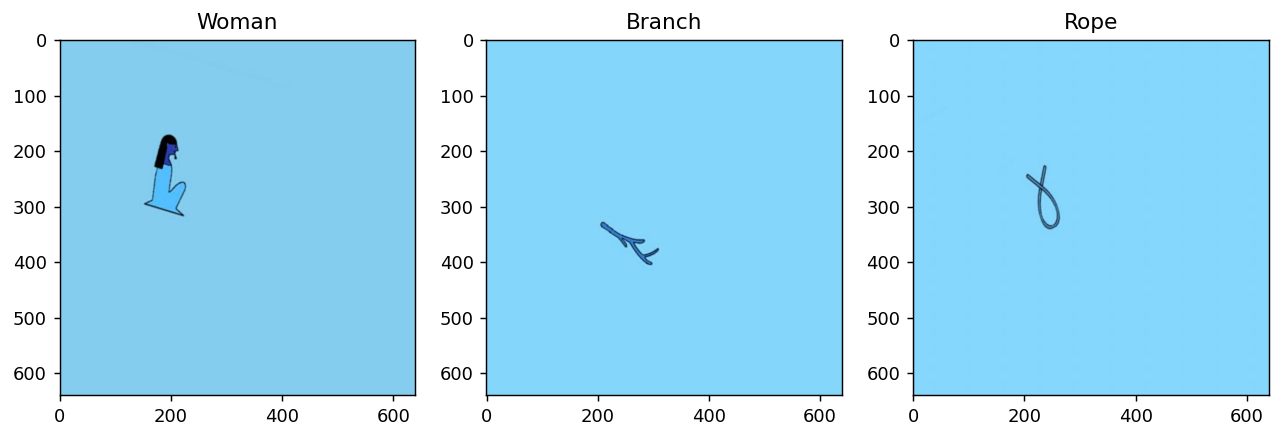

In [29]:
# Training samples

create_random_samples(train_data)

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [30]:
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (250,250))
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, label
    

In [31]:
BATCH_SIZE = 32

train_loader = tf.data.Dataset.from_tensor_slices((train_data['filename'], train_data['class']))
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(train_data.shape[0]).prefetch(BATCH_SIZE) )

val_loader = tf.data.Dataset.from_tensor_slices((val_data['filename'], val_data['class']))
val_dataset = (val_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(val_data.shape[0]).prefetch(BATCH_SIZE) )

test_loader = tf.data.Dataset.from_tensor_slices((test_data['filename'], test_data['class']))
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE) )

# <span style="color:#e74c3c;"> DenseNet </span> Model


In [32]:
pretrained_model = tf.keras.applications.DenseNet169(weights='imagenet',include_top=False ,input_shape=[250,250, 3])
pretrained_model.trainable = True

model = tf.keras.Sequential([
    pretrained_model,
    GlobalAveragePooling2D(),
    
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    
    Dense(len(oe.categories_[0]), activation = 'softmax') #nclasses = 95
    
])

model.compile(optimizer  = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)        │ ?                      │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 12,484,480 (47.62 MB)

 Non-trainable params: 158,400 (618.75 KB)

# <span style="color:#e74c3c;"> Training </span> 


In [33]:
hist = model.fit(train_dataset, epochs = 8 , validation_data = val_dataset, callbacks = [EarlyStopping(min_delta =0.0001, patience = 2)])

Epoch 1/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 1066s 11s/step - accuracy: 0.0288 - loss: 4.6739 - val_accuracy: 0.0077 - val_loss: 4.5789
Epoch 2/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 1179s 14s/step - accuracy: 0.1409 - loss: 3.8596 - val_accuracy: 0.0257 - val_loss: 4.5307
Epoch 3/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 1164s 14s/step - accuracy: 0.3152 - loss: 3.3103 - val_accuracy: 0.0514 - val_loss: 4.3381
Epoch 4/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 1189s 14s/step - accuracy: 0.5045 - loss: 2.8912 - val_accuracy: 0.1388 - val_loss: 3.9601
Epoch 5/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 911s 11s/step - accuracy: 0.6451 - loss: 2.6138 - val_accuracy: 0.2378 - val_loss: 3.6690
Epoch 6/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 887s 10s/step - accuracy: 0.7673 - loss: 2.3287 - val_accuracy: 0.4512 - val_loss: 3.1171
Epoch 7/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 885s 10s/step - accuracy: 0.8334 - loss: 2.1704 - val_accuracy: 0.6697 - val_loss: 2.6344
Epoch 8/8
86/86 ━━━━━━━━━━━━━━━━━━━━ 886s 10s/step - accuracy: 0.9107 - loss: 1.9279 - val_accuracy: 0.7712

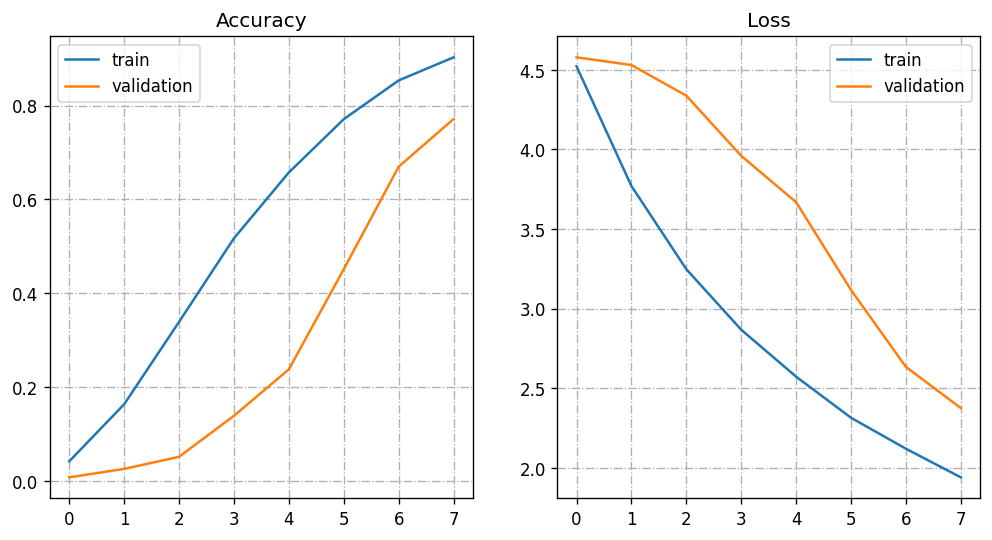

In [34]:
fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 120)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Accuracy")
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].legend(["train", "validation"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Loss")
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].legend(["train", "validation"])

# <span style="color:#e74c3c;"> Evaluation </span> 


In [35]:
test_eval = model.evaluate(test_dataset)
print('test accuracy : {0:.3f} %'.format(test_eval[1]*100))

13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7152 - loss: 2.4672
test accuracy : 73.522 %


# <span style="color:#e74c3c;"> Prediction </span> 


In [36]:
pred = model.predict(test_dataset)
pred_ = np.argmax(pred, axis = 1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


In [37]:
# Classification report 

report = classification_report(np.array(test_data['class']), pred_)
print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00         8
         2.0       1.00      0.33      0.50         3
         3.0       1.00      1.00      1.00         2
         4.0       0.83      0.83      0.83         6
         5.0       0.60      1.00      0.75         3
         6.0       1.00      1.00      1.00         6
         7.0       0.17      1.00      0.29         1
         8.0       0.35      1.00      0.52         7
         9.0       1.00      0.75      0.86         8
        10.0       0.60      0.60      0.60         5
        11.0       0.60      1.00      0.75         3
        12.0       0.33      1.00      0.50         1
        13.0       0.00      0.00      0.00         1
        14.0       1.00      0.67      0.80         3
        15.0       0.67      1.00      0.80         2
        16.0       0.29      1.00      0.44         2
        17.0       0.75    

In [38]:
# Creating random 3 sample from a dataframe

def create_random_samples_and_prediction(data,pred):
    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 150)
    
    idx1 = random.randint(0,data.shape[0])
    img1 = cv2.imread(data['filename'][idx1])
    name1 = oe.inverse_transform(np.array(data['class'][idx1]).reshape(-1,1))[0][0]
    pred1 = oe.inverse_transform(np.array(pred[idx1]).reshape(-1,1))[0][0]
    
    idx2 = random.randint(0,data.shape[0])
    img2 = cv2.imread(data['filename'][idx2])
    name2 = oe.inverse_transform(np.array(data['class'][idx2]).reshape(-1,1))[0][0]
    pred2 = oe.inverse_transform(np.array(pred[idx2]).reshape(-1,1))[0][0]

    idx3 = random.randint(0,data.shape[0])
    img3 = cv2.imread(data['filename'][idx3])
    name3 = oe.inverse_transform(np.array(data['class'][idx3]).reshape(-1,1))[0][0]
    pred3 = oe.inverse_transform(np.array(pred[idx3]).reshape(-1,1))[0][0]
    
    idx4 = random.randint(0,data.shape[0])
    img4 = cv2.imread(data['filename'][idx4])
    name4 = oe.inverse_transform(np.array(data['class'][idx4]).reshape(-1,1))[0][0]
    pred4 = oe.inverse_transform(np.array(pred[idx4]).reshape(-1,1))[0][0]

    
    axs[0].imshow(img1)
    axs[0].set_title("Original class :" + name1 + ", predict :" + pred1, fontsize=8 )

    axs[1].imshow(img2)
    axs[1].set_title("Original class :" + name2 + ", predict :" + pred2, fontsize=8 )
    
    axs[2].imshow(img3)
    axs[2].set_title("Original class :" + name3 + ", predict :" + pred3, fontsize=8 )
    
    axs[3].imshow(img4)
    axs[3].set_title("Original class :" + name4 + ", predict :" + pred4, fontsize=8 )
    
    fig.tight_layout()
    plt.show()

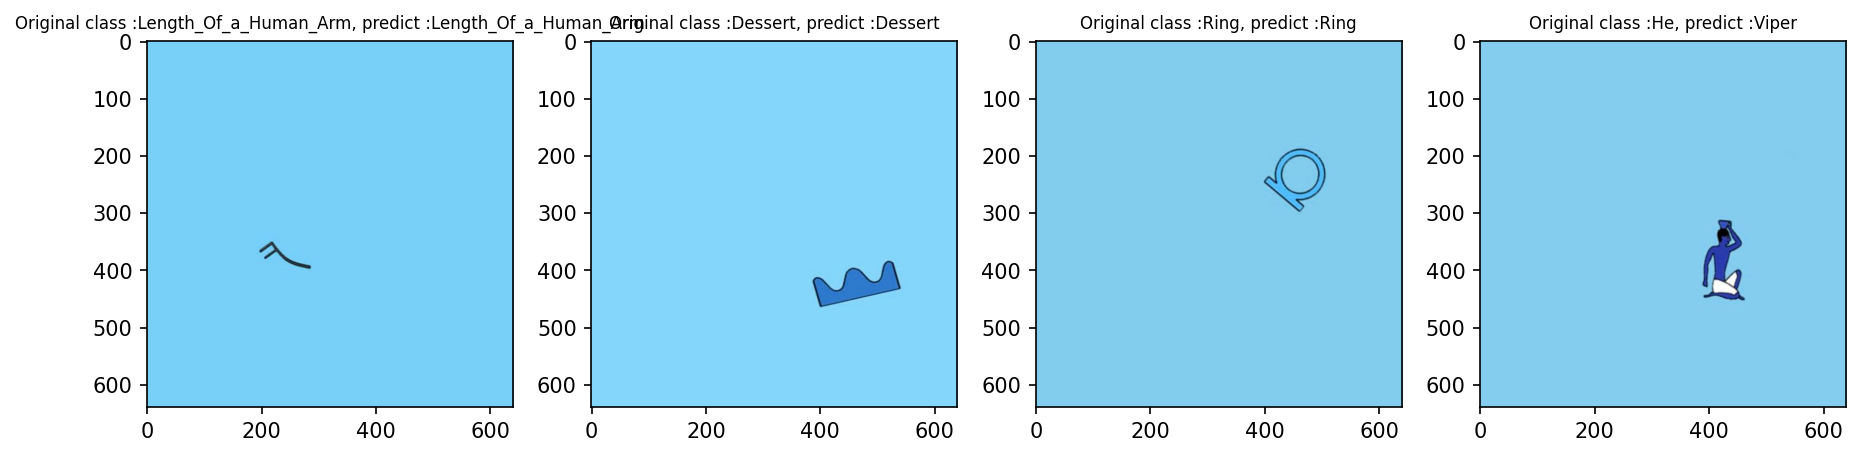

In [39]:
# Original and prediction examples

create_random_samples_and_prediction(test_data, pred_ )

In [40]:
model

<Sequential name=sequential_1, built=True>

In [42]:
import joblib
joblib.dump(model, 'ann_model.pkl')


['ann_model.pkl']

In [43]:
model = joblib.load('ann_model.pkl')


In [45]:
def create_random_samples_and_prediction(data,pred):
    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 150)
    
    idx1 = random.randint(0,data.shape[0])
    img1 = cv2.imread(data['filename'][idx1])
    name1 = oe.inverse_transform(np.array(data['class'][idx1]).reshape(-1,1))[0][0]
    pred1 = oe.inverse_transform(np.array(pred[idx1]).reshape(-1,1))[0][0]
    
    idx2 = random.randint(0,data.shape[0])
    img2 = cv2.imread(data['filename'][idx2])
    name2 = oe.inverse_transform(np.array(data['class'][idx2]).reshape(-1,1))[0][0]
    pred2 = oe.inverse_transform(np.array(pred[idx2]).reshape(-1,1))[0][0]

    idx3 = random.randint(0,data.shape[0])
    img3 = cv2.imread(data['filename'][idx3])
    name3 = oe.inverse_transform(np.array(data['class'][idx3]).reshape(-1,1))[0][0]
    pred3 = oe.inverse_transform(np.array(pred[idx3]).reshape(-1,1))[0][0]
    
    idx4 = random.randint(0,data.shape[0])
    img4 = cv2.imread(data['filename'][idx4])
    name4 = oe.inverse_transform(np.array(data['class'][idx4]).reshape(-1,1))[0][0]
    pred4 = oe.inverse_transform(np.array(pred[idx4]).reshape(-1,1))[0][0]

    
    axs[0].imshow(img1)
    axs[0].set_title("Original class :" + name1 + ", predict :" + pred1, fontsize=8 )

    axs[1].imshow(img2)
    axs[1].set_title("Original class :" + name2 + ", predict :" + pred2, fontsize=8 )
    
    axs[2].imshow(img3)
    axs[2].set_title("Original class :" + name3 + ", predict :" + pred3, fontsize=8 )
    
    axs[3].imshow(img4)
    axs[3].set_title("Original class :" + name4 + ", predict :" + pred4, fontsize=8 )
    
    fig.tight_layout()
    plt.show()

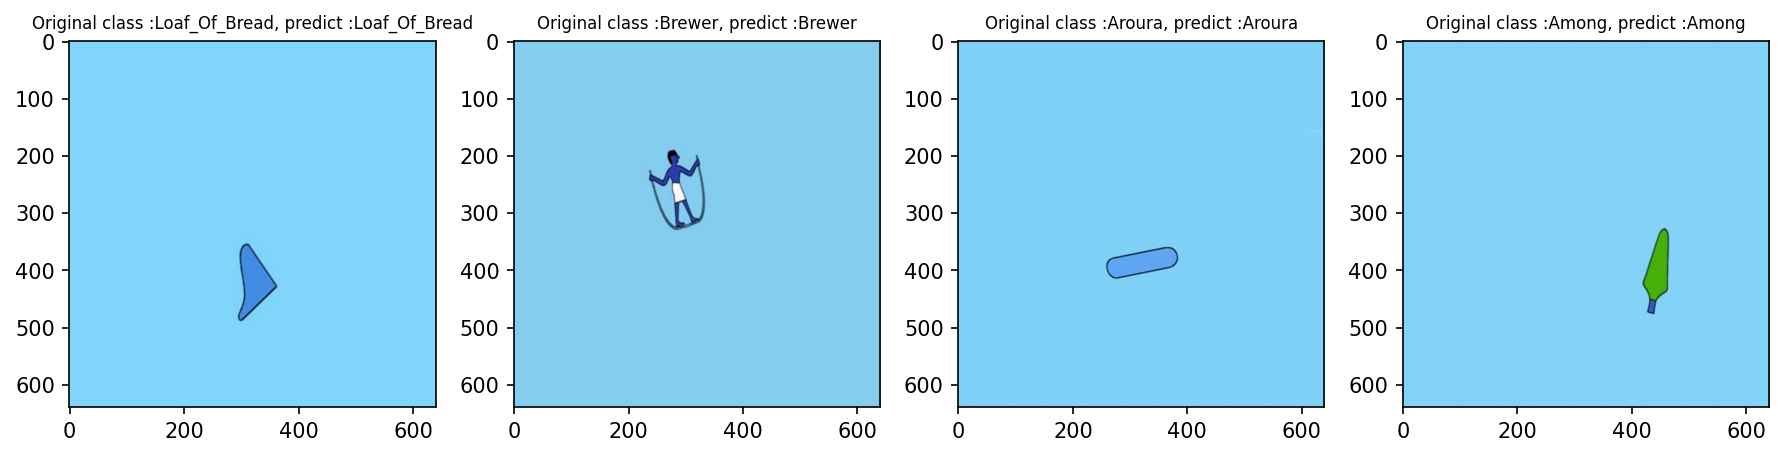

In [46]:
create_random_samples_and_prediction(test_data, pred_ )

In [65]:
from PIL import Image

##Load the image from your test set##
test_image_path = 'C:\\Users\\DELL\\Desktop\\pp\\pp\\archive (2)\\test\\snake-30-_jpg.rf.28913efe2f088d28769bef41dbd9710f.jpg'
img = Image.open(test_image_path)

#Resize the image to match the input size expected by your model (250x250)
img = img.resize((250, 250))

#Convert the image to a numpy array and normalize pixel values
img_array = np.array(img) / 255.0  # Normalize pixel values to range [0, 1]

#Expand dimensions to match the shape expected by the model (1, 250, 250, 3)
img_array = np.expand_dims(img_array, axis=0)

#Make prediction
prediction = model.predict(img_array)[0]

print('Prediction:', prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Prediction: [0.012196   0.00462789 0.01819682 0.00314066 0.00348062 0.01746952
 0.01762221 0.00312744 0.01570069 0.00816174 0.02268921 0.02559367
 0.00640065 0.00577407 0.00393174 0.00429576 0.00704438 0.02496175
 0.00563141 0.00141489 0.00254166 0.00953501 0.0085699  0.00842137
 0.00151972 0.01342748 0.01047773 0.01074372 0.02013536 0.00324645
 0.0095922  0.0073938  0.00233297 0.00839335 0.00673977 0.00515084
 0.00362827 0.00568496 0.00476389 0.004404   0.0021121  0.0139835
 0.00115544 0.0096917  0.00386567 0.01236779 0.00458403 0.00194319
 0.00785564 0.02612767 0.0022045  0.03294987 0.0047506  0.00177155
 0.00797077 0.00536991 0.00675673 0.00150878 0.00780195 0.01450342
 0.00782734 0.01224523 0.00372301 0.00746324 0.01064832 0.01479151
 0.00340647 0.00497351 0.00225191 0.0165706  0.01401407 0.00388944
 0.01797031 0.00345532 0.00268316 0.00974762 0.00246479 0.00657709
 0.01385438 0.00650071 0.21008262 0.00909895 0.00228493 0.00162161
 0.00547706 

In [66]:
#Get the index of the maximum value in the prediction array
predicted_class_index = np.argmax(prediction)

print('Predicted class index:', predicted_class_index)

Predicted class index: 80


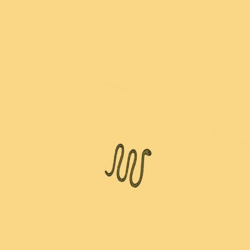

In [67]:
img

In [68]:
oe.categories_[0]

array(['100', 'Among', 'Angry', 'Ankh', 'Aroura', 'At', 'Bad_Thinking',
       'Bandage', 'Bee', 'Belongs', 'Birth', 'Board_Game', 'Book', 'Boy',
       'Branch', 'Bread', 'Brewer', 'Builder', 'Bury', 'Canal',
       'Cloth_on_Pole', 'Cobra', 'Composite_Bow', 'Cooked', 'Corpse',
       'Dessert', 'Divide', 'Duck', 'Elephant', 'Enclosed_Mound', 'Eye',
       'Fabric', 'Face', 'Falcon', 'Fingre', 'Fish', 'Flail',
       'Folded_Cloth', 'Foot', 'Galena', 'Giraffe', 'He', 'Her', 'Hit',
       'Horn', 'King', 'Leg', 'Length_Of_a_Human_Arm', 'Life_Spirit',
       'Limit', 'Lion', 'Lizard', 'Loaf', 'Loaf_Of_Bread', 'Man',
       'Mascot', 'Meet', 'Mother', 'Mouth', 'Musical_Instrument',
       'Nile_Fish', 'Not', 'Now', 'Nurse', 'Nursing', 'Occur', 'One',
       'Owl', 'Pair', 'Papyrus_Scroll', 'Pool', 'QuailChick', 'Reed',
       'Ring', 'Rope', 'Ruler', 'Sail', 'Sandal', 'Semen', 'Small_Ring',
       'Snake', 'Soldier', 'Star', 'Stick', 'Swallow', 'This',
       'To_Be_Dead', 'To_Protect', 

In [70]:
oe.categories_[0][80]

'Snake'